# Link to Source Code
[perceptron.py](https://github.com/CameronHudson813/CameronHudson813.github.io/blob/main/posts/Implementing%20Perceptron/perceptron.py)

# Abstract
Today, I will show my implementation of the Perceptron algorithm that creates hyperplanes that seperate data and show its behavior through various experiments. I discovered through this process that the perceptron algorithm cannot reach a loss of 0 when dealing with data that is not linearly seperable, and so a maximum number of iterations must be specified, however if the data is linearly seperable, the perceptron algorithm is gauranteed to reach a loss of 0. I also discovered that the perceptron algorithm works on data of greater dimensions than 2, and can indeed reach a loss of 0 in these cases as well. 

# Perceptron Grad Function
One of key functions used in `perceptron.py()`'s implementation of the perceptron algorithm is the `grad()` function. This translates the math of the perceptron update to code. We first calculate the score of `X` which is the result of the dot product of a row of the feature matrix `X` with the weight vector `w`, which is initally filled with random values between 0 and 1. Afterwards, we compute `misclassified`, which is defined as `misclassified = score_i * (2*y - 1) < 0` which returns a boolean value `True` or `False` depending on if the random point we picked is classified correctly or not by line created by weight vector `w`. We use `2*y-1` to convert y from being a `0` or `1` value to a `-1` or `1` value. We multiply this by our previously calculated score, and if this product is less than 0, we consider this point misclassified. `misclassified` is then used in the return value `(-1 * misclassified) * ((2*y - 1) * X)`. If the point is misclassified, then grad will return `((2*y - 1) * X)`, which is subtracted by the weight vector `w` in the `step()` function, which corresponds to optimizing weight vector `w`. If `misclassified` = 0, then the function will return 0, because we do not need to update the weight vector if the point is classified correctly.

In [1]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

# Checking Implementation
We now do some stuff to check the implementation of Perceptron and PerceptronOptimizer

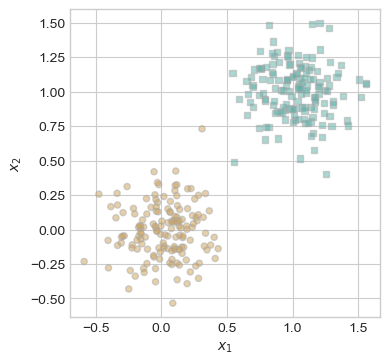

In [2]:
#Written by Professor Chodrow
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points, noise, p_dims):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=2)
plot_perceptron_data(X, y, ax)

# Experiments
We conduct a few experiments regarding the perceptron algorithm to show its behavior on data that is linearly seperable, data that isn't linearly seperable, and data with more than 2 dimensions. 

## Perceptron Algorithm on Linearly Seperable Data
Here, we will define the code that usings the functions from `percepton.py` to demonstrate the perceptron algorithm's behavior on linearly seperable data.

In [3]:
#Written by Professor Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


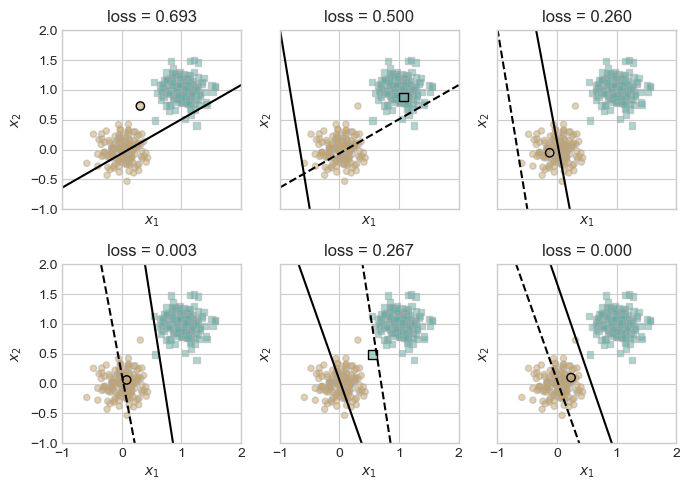

In [99]:
#Written by Professor Chodrow
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
n = X.size()[0]

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

## Perceptron Algorithm on Non-Linearly Seperable Data
In non-linearly seperable data, the loss function will not reach 0. In our original code, because of the while loop `while loss < 0`, we will have an infinitely running loop in the case of non-linearly seperable data. To still show that the perceptron algorithm does attempt to seperate non-linearly seperable data, we will modify the code to halt after 1000 iterations, regardless if loss ever reaches 0 or not.

We create a function similar to `perceptron_data()`, except we increase the noise in order to make a set of data that is not linearly seperable.

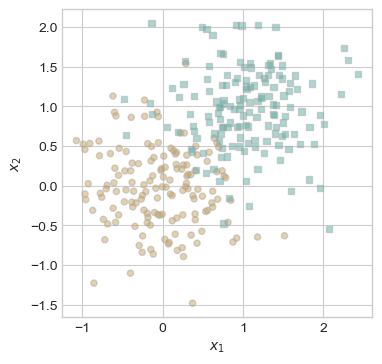

In [38]:
def not_seperable_data(n_points, noise, p_dims):
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = not_seperable_data(300, 0.5, 2)
plot_perceptron_data(X,y,ax)

Then, slightly modify the code we used previously to show how the loss function updates the hyperplane, except we change our original while loop to `while iterations < 1000`, increment iterations by 1 after each loop, and modify the original code so that we see the percptron's loss and hyperplane every 200 iterations. 

TypeError: PerceptronOptimizer.step() missing 2 required positional arguments: 'alpha' and 'k'

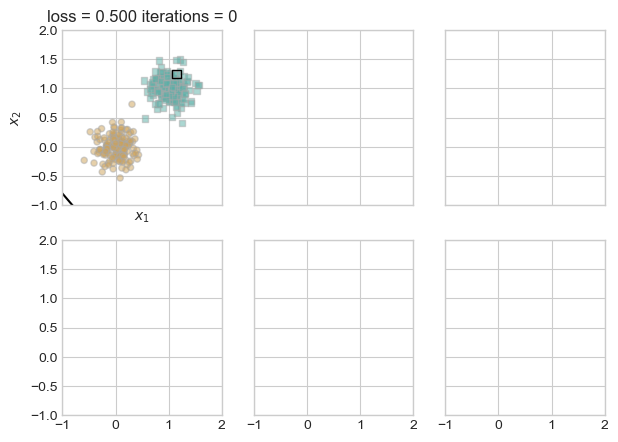

In [88]:
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
iterations = 0
n = X.size()[0]

while iterations <= 1000:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if iterations % 200 == 0:
        plot_perceptron_data(X, y, ax)
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        # This highlights the point choosen in each iteration
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f} iterations = {iterations}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
    iterations+=1
plt.tight_layout()

## Results
Here we see that though it could not reach 0% loss, because the data is not linearly seperable, it still did a fairly good job in finding a hyperplane that seperated the data in 1000 iterations.

## More than 2 Dimensions
The perceptron algorithm is able to generate hyperplanes that seperate linearly seperable data that is more than just two dimensions. Below is an example of data with 5 features which corresponds to five dimensions. In the proceeding code, we will use the `perceptron_data()` function used either, only now we will define 5 dimensions instead of 2.

In [ ]:
X, y = perceptron_data(300, 0.2, 5)

## Loss Evolution
We will then make a modified version of the code earlier to assess how the loss evolves through Perceptron's iterations.

In [78]:
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

iter_loss = []
iterations = 0
n = X.size()[0]

while iterations <= 1000:
     i = torch.randint(n, size = (1,))
     x_i = X[[i],:]
     y_i = y[i]
     opt.step(x_i, y_i)


     if (iterations % 200 == 0):
          iter_loss.append(p.loss(X, y).item())
     iterations+=1

print(iter_loss)


[0.4333333373069763, 0.0033333334140479565, 0.0033333334140479565, 0.0033333334140479565, 0.05999999865889549, 0.0]


## Results
Based on the losses calcuated every 200 iterations, we can conclude from the final loss function of 0 that this set of data is indeed linearly seperable.

# Minibatch Perceptron

IndexError: index 6 is out of bounds for axis 0 with size 6

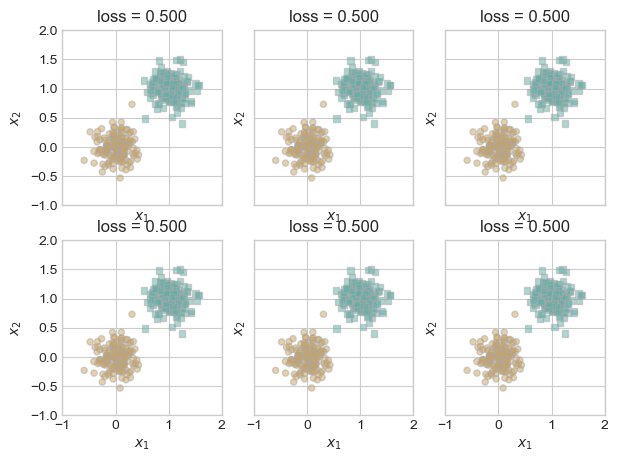

In [106]:
#Written by Professor Chodrow
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []
n = X.size()[0]
k = 5

while loss > 0:
    ax = axarr.ravel()[current_ax]
    ix = torch.randperm(X.size(0))[:k]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    #So instead of picking a random point, we want to pick 5 random ones and then average them
    # i = torch.randint(n, size = (1,))
    local_loss = p.loss(x_i, y_i).item()
    if local_loss > 0:
        opt.step(x_i, y_i, 0.82, 5)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        # ax.scatter(X[ix,0],X[ix,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

# Runtime Complexity
In order to analyze the runtime complexity of one run of the perceptron algorithm, we must first follow the order of events that occur when calling `PerceptronOptimizer.step()` (which does one step of the perceptron algorithm) and understand the runtime complexity of those events. The `step()` function calls`PerceptronOptimizer.loss()` and `PerceptronOptimizer.grad()`, whose runtimes are as follows:

## `PerceptronOptimizer.loss()` Runtime Complexity
This function takes in two tensors `X` and `y` and returns a percentage. In order to do this we must call the `score()` function which computes the dot product of our current weight vector and all of the rows of `X`, corresponding to feature vectors. This `score()` function has us do a `O(p)` operation (where `p` is the number of features) `n` times (where `n` is the number of points or rows in `X`). So far our overall runtime complexity is `O(n*p)`. After calculating the score, which multiples the each value in the score tensor to each value in the y_ tensor, evalutes whether this product is > or < than 0, converts the `True` and `False` values to 1's and 0's, sums these values, and divides it by the total number of score values. The rest of these operations listed are all linear, so our overall time complexity remains `O(n*p)`.

## `PerceptronOptimizer.grad()` Runtime Complexity
This function also calls the `score()` function, which we have previous disovered is an `O(n*p)` operation, and store the result in `score_i`. Afterwards, we perform operations on the result of `score_i` which we store in `misclassified`, and yet again perform operations on `misclassified` which which are returned as the function's output. The rest of these operations are `O(n)`, and thus our overall time complexity of this function `O(n*p)`.

## Overall Time Complexity
The big-O complexity of `PerceptronOptimizer.step()`, because its most taxing operation had a time complexity of `O(n*p)`, is thus `O(n*p)`.

